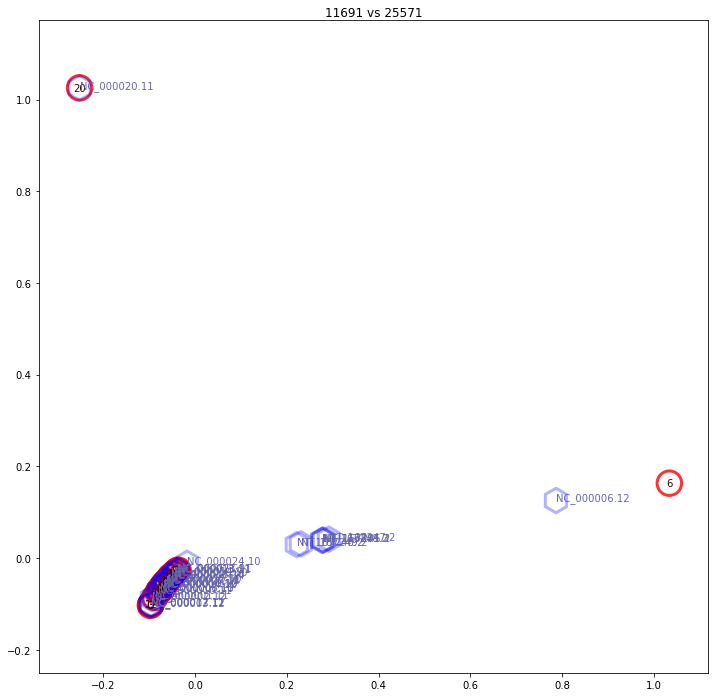

In [28]:
from glob import glob
import json
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd

from kernel import kernel2
from clean import cleanChr
np.set_printoptions(precision=4)

%matplotlib inline
import mpld3
mpld3.enable_notebook()

gids = ['11691', '25571']#,'7057','28918','4242','28814']
meta = {}
chrNames = [0,0]
for j,gid in enumerate(gids):
    with open('ks/meta/'+gid) as meta_file:    
        meta[gid] = json.load(meta_file)
        chrNames[j] = [i['name'] for i in meta[gid]['chromosomes'] if i['gene_count']>250]
        ##cleanChr(gids[0],gids[1])

chrNamesComb = chrNames[0] + chrNames[1]
K = pd.DataFrame(
        data = np.eye(len(chrNamesComb)), 
        index = chrNamesComb, 
        columns = chrNamesComb)

#build K, the chr ks matrix, each entry is a dot product
#measure of a chromosome pair
for fpath in glob('ks/cleanChrTmp/*.*'):
    s = fpath.split('/')[-1].split('|')
    gid1 = s[0].split('_')[0]
    gid2 = s[1].split('_')[0]
    #print gid1, gid2
    chr1 = s[0].split('_')[-1]
    chr2 = s[1].split('_')[1:]
    chr2 = '_'.join(chr2)
    #print chr1, chr2
    if chr1 in chrNames[0] and chr2 in chrNames[1]:
        df = pd.read_csv(fpath,
                        header = None,
                        sep = '\t',
                        )
    
        n1 = filter(lambda o: o['name']==chr1, meta[gid1]['chromosomes'])
        n2 = filter(lambda o: o['name']==chr2, meta[gid2]['chromosomes'])
        #print n1,n2
        n1 = n1[0]['gene_count'] if len(n1)>0 else (  len(set(df[1])) or 1  )
        n2 = n2[0]['gene_count'] if len(n2)>0 else (  len(set(df[2])) or 1  )
        #print n1,n2
        k = kernel2(df, 1, n1, n2)
        K[chr1][chr2] = k
        K[chr2][chr1] = k

pca = PCA(n_components = 3)
pca.fit(K)
x = pca.transform(K)

colors = ['r' if c in chrNames[0] else 'b' for c in K.index] 
x1 = np.array([x[i] for i in range(len(x)) if colors[i]=='r'])
x2 = np.array([x[i] for i in range(len(x)) if colors[i]=='b'])

plt.figure(figsize=(12,12))

#plt.scatter(x[:,0],x[:,1], c=colors, alpha=0.3, s=200)


plt.scatter(x1[:,0],x1[:,1], 
        edgecolors='r', marker='o', linewidth=3,
        alpha=0.8, s=600, facecolors='none')

plt.scatter(x2[:,0],x2[:,1], 
        edgecolors='b', marker='h', linewidth=3,
        alpha=0.3, s=600, facecolors='none')


plt.axis('equal')

for i,tag in enumerate(K.index):
    if tag in chrNames[1]:
        halign = 'left'
        valign = 'baseline'
        color = '#6666aa'
        dx,dy = 0.0005,-0.0001
    else:
        halign = 'center'
        valign = 'center'
        color = '#330000'
        dx,dy = 0,0

    plt.annotate(tag,
            xy=(x[i,0],x[i,1]),
            xytext=(x[i,0]+dx,x[i,1]+dy),
            color = color,
            horizontalalignment = halign,
            verticalalignment = valign,
            alpha = 1)

plt.title(gids[0] + ' vs ' + gids[1])

plt.show()